In [1]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# importing Qiskit
from qiskit import BasicAer, IBMQ
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit.compiler import transpile
from qiskit.tools.visualization import plot_histogram

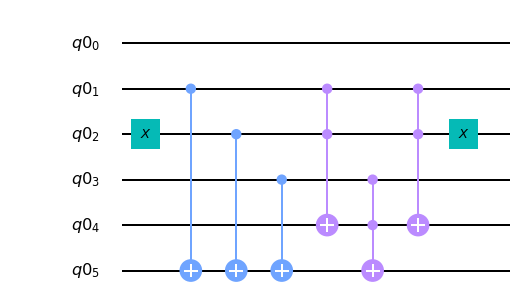

In [2]:
q = QuantumRegister(6)
qc = QuantumCircuit(q)
qc.x(q[2])
qc.cx(q[1], q[5])
qc.cx(q[2], q[5])
qc.cx(q[3], q[5])
qc.ccx(q[1], q[2], q[4])
qc.ccx(q[3], q[4], q[5])
qc.ccx(q[1], q[2], q[4])
qc.x(q[2])
qc.draw(output='mpl')

In [3]:
def black_box_u_f(circuit, f_in, f_out, aux, n, exactly_1_3_sat_formula):
    num_clauses = len(exactly_1_3_sat_formula)
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        # This loop ensures aux[k] is 1 if an odd number of literals
        # are true
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        # Flip aux[k] if all literals are true, using auxiliary qubit
        # (ancilla) aux[num_clauses]
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        # Flip back to reverse state of negative literals and ancilla
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])
    # The formula is satisfied if and only if all auxiliary qubits
    # except aux[num_clauses] are 1
    if (num_clauses == 1):
        circuit.cx(aux[0], f_out[0])
    elif (num_clauses == 2):
        circuit.ccx(aux[0], aux[1], f_out[0])
    elif (num_clauses == 3):
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
        circuit.ccx(aux[2], aux[num_clauses], f_out[0])
        circuit.ccx(aux[0], aux[1], aux[num_clauses])
    else:
        raise ValueError('We only allow at most 3 clauses')
    # Flip back any auxiliary qubits to make sure state is consistent
    # for future executions of this routine; same loop as above.
    for (k, clause) in enumerate(exactly_1_3_sat_formula):
        for literal in clause:
            if literal > 0:
                circuit.cx(f_in[literal-1], aux[k])
            else:
                circuit.x(f_in[-literal-1])
                circuit.cx(f_in[-literal-1], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        circuit.ccx(f_in[2], aux[num_clauses], aux[k])
        circuit.ccx(f_in[0], f_in[1], aux[num_clauses])
        for literal in clause:
            if literal < 0:
                circuit.x(f_in[-literal-1])


In [4]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 ' +
                         'controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)
# -- end function

In [5]:
def inversion_about_average(circuit, f_in, n):
    """Apply inversion about the average step of Grover's algorithm."""
    # Hadamards everywhere
    for j in range(n):
        circuit.h(f_in[j])
    # D matrix: flips the sign of the state |000> only
    for j in range(n):
        circuit.x(f_in[j])
    n_controlled_Z(circuit, [f_in[j] for j in range(n-1)], f_in[n-1])
    for j in range(n):
        circuit.x(f_in[j])
    # Hadamards everywhere again
    for j in range(n):
        circuit.h(f_in[j])
# -- end function

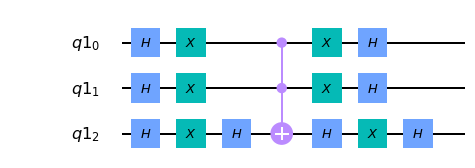

In [6]:
qr = QuantumRegister(3)
qInvAvg = QuantumCircuit(qr)
inversion_about_average(qInvAvg, qr, 3)
qInvAvg.draw(output='mpl')

In [13]:
def input_state(circuit, f_in, f_out, n):
    """(n+1)-qubit input state for Grover search."""
    for j in range(n):
        circuit.h(f_in[j])
    circuit.x(f_out)
    circuit.h(f_out)
# -- end function

# Make a quantum program for the n-bit Grover search.
n = 3

# Exactly-1 3-SAT formula to be satisfied, in conjunctive
# normal form. We represent literals with integers, positive or
# negative, to indicate a Boolean variable or its negation.
exactly_1_3_sat_formula = [[1, 2, -3], [-1, -2, -3], [-1, 2, 3]]

# Define three quantum registers: 'f_in' is the search space (input
# to the function f), 'f_out' is bit used for the output of function
# f, aux are the auxiliary bits used by f to perform its
# computation.
f_in = QuantumRegister(n)
f_out = QuantumRegister(1)
aux = QuantumRegister(len(exactly_1_3_sat_formula) + 1)

# Define classical register for algorithm result
ans = ClassicalRegister(n)

# Define quantum circuit with above registers
grover = QuantumCircuit()
grover.add_register(f_in)
grover.add_register(f_out)
grover.add_register(aux)
grover.add_register(ans)

input_state(grover, f_in, f_out, n)
T = 2
for t in range(T):
    # Apply T full iterations
    black_box_u_f(grover, f_in, f_out, aux, n, exactly_1_3_sat_formula)
    inversion_about_average(grover, f_in, n)

# Measure the output register in the computational basis
for j in range(n):
    grover.measure(f_in[j], ans[j])

# Execute circuit
#backend = BasicAer.get_backend('qasm_simulator')
#job = execute([grover], backend=backend, shots=1000)
#result = job.result()

# Get counts and plot histogram
#counts = result.get_counts(grover)
#plot_histogram(counts)

In [14]:
IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [15]:
# get ibmq_16_melbourne configuration and coupling map
provider = IBMQ.get_provider('ibm-q')
qcomp = provider.get_backend('ibmq_16_melbourne')

job = execute([grover], backend=qcomp)


In [16]:
from qiskit.tools.monitor import job_monitor

In [17]:
job_monitor(job)

Job Status: job incurred error     


result = job.result()

In [19]:
result = job.result()
plot_histogram(result.get_counts(grover))

IBMQJobFailureError: 'Unable to retrieve job result. Job has failed. Use job.error_message() to get more details.'